# 2.2 Datasetの実装、 2.3 DataLoaderの実装

本ファイルでは、SSDなど物体検出アルゴリズム用のDatasetとDataLoaderを作成します。

VOC2012データセットを対象とします。


# 2.2 学習目標

1.	物体検出で使用するDatasetクラスを作成できるようになる
2.	SSDの学習時のデータオーギュメンテーションで、何をしているのかを理解する



# 2.3 学習目標

1.	物体検出で使用するDataLoaderクラスを作成できるようになる



# 事前準備


OpenCVのインストール

- pip install opencv-python

本書の指示に従い、VOC2010のデータセットをダウンロード

- http://host.robots.ox.ac.uk/pascal/VOC/voc2012/



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# パッケージのimport
from pathlib import Path
import random
# XMLをファイルやテキストから読み込んだり、加工したり、
# 保存したりするためのライブラリ
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

%matplotlib inline
%load_ext blackcellmagic

In [3]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

## Randomly sort annotated files

In [4]:
remake_files = False
if remake_files:
    all_files = sorted([file.stem for file in Path('./data/annots/object-view/').glob("*.json")])
    train_size = int(len(all_files) * 0.8)
    val_size = len(all_files) - train_size
    trainset, valset = torch.utils.data.random_split(all_files, [train_size, val_size])

    trainlist = [trainset.dataset[i] for i in trainset.indices]
    vallist = [valset.dataset[i] for i in valset.indices]

    with open('./data/train_list.txt', 'w') as f:
        f.write("\n".join(trainlist))

    with open('./data/val_list.txt', 'w') as f:
        f.write("\n".join(vallist))

# 画像データ、アノテーションデータへのファイルパスのリストを作成する

In [5]:
from pytorch_advanced.c02_ssd.ssd_model import make_data_path_list
from pytorch_advanced.c02_ssd.ssd_model_mob import make_datapath_list_zumen

/Users/shotashimizu/github.com/banbiossa/pytorch_advanced/.venv/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [14]:
# ファイルパスのリストを作成
rootpath = Path("./data/VOCdevkit/VOC2012/")
train_img_list, train_anno_list, val_img_list, val_anno_list = make_data_path_list(
    rootpath
)

# 動作確認
print(train_img_list[0])
print(val_anno_list[0])

data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg
data/VOCdevkit/VOC2012/Annotations/2008_000002.xml


In [15]:
train_img_list_menzu, train_anno_list_menzu, val_img_list_menzu, val_anno_list_menzu = make_datapath_list_zumen(Path("."))
print(train_img_list_menzu[0])
print(val_anno_list_menzu[0])

data/images/0116.png
data/annots/object-view/0179.json


# xml形式のアノテーションデータをリストに変換する

In [8]:
from pytorch_advanced.c02_ssd.ssd_model import AnnoXML2List
from pytorch_advanced.c02_ssd.ssd_model_mob import voc_from_anocci_json

In [16]:
# 動作確認　
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

transform_anno = AnnoXML2List(voc_classes)

In [17]:
ind = 1
image_file_path = val_img_list[ind]
img = cv2.imread(str(image_file_path))
height, width, channels = img.shape

xml_path = val_anno_list[ind]

In [18]:
transform_anno(xml_path, width, height)

array([[ 0.09      ,  0.03003003,  0.998     ,  0.996997  , 18.        ],
       [ 0.122     ,  0.56756757,  0.164     ,  0.72672673, 14.        ]])

In [23]:
ind = 1
image_file_path_menzu = val_img_list_menzu[ind]
img = cv2.imread(str(image_file_path_menzu))
height, width, channels = img.shape

json_path = val_anno_list_menzu[ind]

In [25]:
voc_from_anocci_json(json_path)

array([[0.21509983, 0.3507007 , 0.61007285, 0.7246137 , 1.        ]],
      dtype=float32)

# 画像とアノテーションの前処理を行うクラスDataTransformを作成する

In [26]:
from pytorch_advanced.c02_ssd.ssd_model import DataTransform

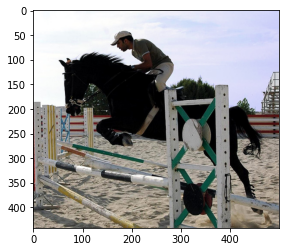

In [31]:
# 1. 読み込み
image_file_path = train_img_list[0]
img = cv2.imread(str(image_file_path))
height, width, channels = img.shape

# 2. アノテーションをリストに
transform_anno = AnnoXML2List(voc_classes)
anno_list = transform_anno(train_anno_list[0], width, height)

# 3. 元画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 前処理クラス
color_mean = (104, 117, 123)
input_size = 300
tranform = DataTransform(input_size, color_mean)

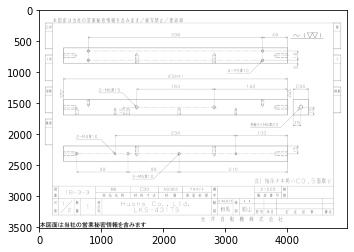

In [84]:
# menzu
# 1. 読み込み
image_file_path_menzu = train_img_list_menzu[0]
img_menzu = cv2.imread(str(image_file_path_menzu))
# height, width, channels = img.shape

# 2. アノテーションをリストに
anno_list_menzu = voc_from_anocci_json(train_anno_list_menzu[0])

# 3. 元画像の表示
plt.imshow(cv2.cvtColor(img_menzu, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 前処理クラス
color_mean = (200, 200, 200)
input_size = 1000
tranform_menzu = DataTransform(input_size, color_mean)

/Users/shotashimizu/github.com/banbiossa/pytorch_advanced/pytorch_advanced/c02_ssd/data_augumentation.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


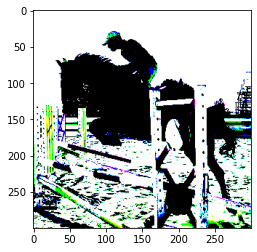

In [73]:
# 5. train 画像の表示
phase = "train"
img_transformed, boxes, labels= tranform(img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


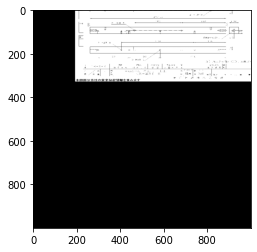

In [85]:
# 5. train 画像の表示
phase = "train"
img_transformed_menzu, boxes_menzu, labels_menzu = tranform_menzu(img_menzu, phase, anno_list_menzu[:, :4], anno_list_menzu[:, 4])
plt.imshow(cv2.cvtColor(img_transformed_menzu, cv2.COLOR_BGR2RGB))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


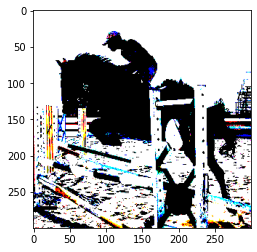

In [79]:
# 6. val 画像の表示
phase = "val"
img_transformed, boxes, labels = tranform(img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


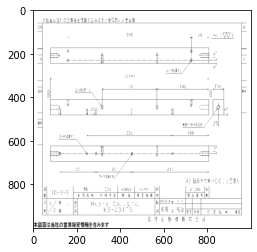

In [86]:
# 6. val 画像の表示
phase = "val"
img_transformed_menzu, boxes_menzu, labels_menzu = tranform_menzu(
    img_menzu, phase, anno_list_menzu[:, :4], anno_list_menzu[:, 4]
)
plt.imshow(cv2.cvtColor(img_transformed_menzu, cv2.COLOR_BGR2RGB))
plt.show()

# Datasetを作成する

In [63]:
from pytorch_advanced.c02_ssd.ssd_model import VOCDataset

In [64]:
color_mean = (104, 117, 123)
input_size = 300

train_dataset = VOCDataset(
    train_img_list,
    train_anno_list,
    phase="train",
    transform=DataTransform(input_size, color_mean),
    transform_anno = AnnoXML2List(voc_classes),
)

val_dataset = VOCDataset(
    val_img_list,
    val_anno_list,
    phase="val",
    transform=DataTransform(input_size, color_mean),
    transform_anno = AnnoXML2List(voc_classes),
)

In [65]:
val_dataset[1]

(tensor([[[   0.9417,    6.1650,   11.1283,  ...,  -22.9082,  -13.2200,
             -9.4034],
          [   6.4367,    9.6600,   13.8283,  ...,  -21.4433,  -18.6500,
            -18.2033],
          [  10.8833,   13.5500,   16.7000,  ...,  -20.9917,  -24.5250,
            -25.1917],
          ...,
          [ -23.9501,  -14.9000,   -1.7583,  ..., -108.6083, -111.0000,
           -117.8083],
          [ -28.2816,  -20.1750,   -5.5633,  ..., -104.9934, -111.8350,
           -119.0000],
          [ -20.4766,  -21.0000,  -12.6334,  ..., -107.1685, -115.7800,
           -117.1100]],
 
         [[  25.9417,   30.1650,   35.1283,  ...,  -18.0766,  -14.7250,
            -11.8534],
          [  31.4367,   33.6600,   37.8283,  ...,  -13.5016,  -10.8250,
            -10.3783],
          [  35.7917,   37.5500,   40.7000,  ...,  -11.8417,  -13.0750,
            -14.0167],
          ...,
          [  -1.9501,    7.1000,   20.2417,  ..., -101.9083, -102.0000,
           -109.7167],
          [  -6.2

In [87]:
color_mean = (200, 200, 200)
input_size = 1000

train_dataset_menzu = VOCDataset(
    train_img_list_menzu,
    train_anno_list_menzu,
    phase="train",
    transform=DataTransform(input_size, color_mean),
    transform_anno = voc_from_anocci_json, 
)

val_dataset_menzu = VOCDataset(
    val_img_list_menzu,
    val_anno_list_menzu,
    phase="val",
    transform=DataTransform(input_size, color_mean),
    transform_anno = voc_from_anocci_json,
)

In [88]:
val_dataset_menzu[1]

(tensor([[[55., 55., 55.,  ..., 55., 55., 55.],
          [55., 55., 55.,  ..., 55., 55., 55.],
          [55., 55., 55.,  ..., 55., 55., 55.],
          ...,
          [55., 55., 55.,  ..., 55., 55., 55.],
          [55., 55., 55.,  ..., 55., 55., 55.],
          [55., 55., 55.,  ..., 55., 55., 55.]],
 
         [[55., 55., 55.,  ..., 55., 55., 55.],
          [55., 55., 55.,  ..., 55., 55., 55.],
          [55., 55., 55.,  ..., 55., 55., 55.],
          ...,
          [55., 55., 55.,  ..., 55., 55., 55.],
          [55., 55., 55.,  ..., 55., 55., 55.],
          [55., 55., 55.,  ..., 55., 55., 55.]],
 
         [[55., 55., 55.,  ..., 55., 55., 55.],
          [55., 55., 55.,  ..., 55., 55., 55.],
          [55., 55., 55.,  ..., 55., 55., 55.],
          ...,
          [55., 55., 55.,  ..., 55., 55., 55.],
          [55., 55., 55.,  ..., 55., 55., 55.],
          [55., 55., 55.,  ..., 55., 55., 55.]]]),
 array([[0.21509983, 0.3507007 , 0.61007285, 0.7246137 , 1.        ]],
       dtyp

# DataLoaderを作成する

In [89]:
from pytorch_advanced.c02_ssd.ssd_model import od_collate_fn

In [90]:
# data loader
batch_size = 4
train_dataloader = data.DataLoader(
    train_dataset, 
    batch_size = batch_size,
    shuffle=True,
    collate_fn = od_collate_fn,
)

val_dataloader = data.DataLoader(
    val_dataset, 
    batch_size = batch_size,
    shuffle=True,
    collate_fn = od_collate_fn,
)

dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

In [91]:
# 動作の確認
batch_iterator = iter(dataloaders_dict["val"])
images, targets = next(batch_iterator)
print(images.size())
print(len(targets))
print(targets[1].size())

torch.Size([4, 3, 300, 300])
4
torch.Size([1, 5])


In [92]:
targets

[tensor([[ 0.0000,  0.1280,  0.9980,  0.6720,  0.0000],
         [ 0.6200,  0.4133,  0.7400,  0.8800, 14.0000]]),
 tensor([[0.0000, 0.0749, 0.9980, 0.6916, 7.0000]]),
 tensor([[0.4853, 0.1580, 0.9947, 0.5460, 2.0000]]),
 tensor([[0.3950, 0.1980, 0.5862, 0.6860, 4.0000]])]

In [93]:
# data loader
batch_size = 4
train_dataloader_menzu = data.DataLoader(
    train_dataset_menzu, 
    batch_size = batch_size,
    shuffle=True,
    collate_fn = od_collate_fn,
)

val_dataloader_menzu = data.DataLoader(
    val_dataset_menzu, 
    batch_size = batch_size,
    shuffle=True,
    collate_fn = od_collate_fn,
)

dataloaders_dict_menzu = {"train": train_dataloader_menzu, "val": val_dataloader_menzu}

In [100]:
# 動作の確認
batch_iterator_menzu = iter(dataloaders_dict_menzu["train"])
images, targets = next(batch_iterator_menzu)
print(images.size())
print(len(targets))
print(targets[1].size())

/Users/shotashimizu/github.com/banbiossa/pytorch_advanced/pytorch_advanced/c02_ssd/data_augumentation.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)


torch.Size([4, 3, 1000, 1000])
4
torch.Size([1, 5])


In [101]:
targets

[tensor([[0.1209, 0.0546, 0.1626, 0.1059, 1.0000],
         [0.1209, 0.1298, 0.1625, 0.1530, 1.0000],
         [0.2178, 0.1297, 0.2536, 0.1528, 1.0000]]),
 tensor([[0.6692, 0.3275, 1.5827, 0.5979, 1.0000]]),
 tensor([[-0.8441,  0.3162,  1.0000,  0.4427,  1.0000],
         [-0.1857,  0.6652,  0.9292,  0.8231,  1.0000]]),
 tensor([[0.1128, 0.3479, 0.7342, 0.5307, 1.0000],
         [0.7912, 0.3474, 0.8869, 0.5257, 1.0000],
         [0.1135, 0.6421, 0.7353, 0.6848, 1.0000]])]

In [98]:
print(len(train_dataset))
print(len(val_dataset))

5717
5823


In [99]:
print(len(train_dataset_menzu))
print(len(val_dataset_menzu))

334
84


以上